# Prediction Fuel Efficiency of Vehicles

<p align="center">
<img src="../img/fuel-vehicle.jpg">
</p>

## Problem Statement

The data contains MPG variable which is continuous data and tells us about the efficiency of fuel consumption of a vehicle in 70s and 80s.

Our aim here is to predict the MPG value for a vehicle given we have other attributes of the vehicle.

In this series, we'd be going from data collection to deploying the Machine Learning model:

1. **Data Collection** - we are using the classic Auto MPG dataset from UCI ML Repository.
2. **Define Problem Statement** - We'll frame the problem based on the dataset description and initial exploration.
3. **EDA** - Carry our exploratory analysis to figure out the important features and creating new combination of features.
4. **Data Preparation** - Using step 4, create a pipeline of tasks to transform the data to be loaded into our ML models.
5. **Selecting and Training ML models** - Training a few models to evaluate their predictions using cross-validation.
6. **Hyperparameter Tuning** - Fine tune the hyperparameters for the models that showed promissing results.
7. **Deploy the Model using a web service** - Using Flask web framework to deploy our trained model on Heroku.

## Imports

In [8]:
# importing a few general use case libraries
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing   import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

## Step 1: Collecting data from UCI ML repository

In [2]:
cols = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin']

df_raw = pd.read_csv( "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data", sep=' ',
                    names=cols, na_values = '?', comment = '\t', skipinitialspace=True)

df_raw.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [3]:
df1 = df_raw.copy()

## Step 2: Exploratory Data Analysis

1. Check for Data type of columns
2. Check for null values
3. Check for outliers
4. Look for the category distribution in categorical columns
5. Plot for correlation
6. Look for new variables

In [15]:
# checking the data info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [17]:
# checking for all the null values
df1.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [18]:
# summary statistics of quantitive variables
df1.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


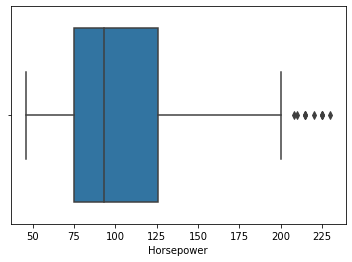

In [5]:
sns.boxplot(x=df1['Horsepower'])

In [4]:
# imputing the values with median
median = df1['Horsepower'].median()
df1['Horsepower'] = df1['Horsepower'].fillna(median)

In [11]:
# category distribution
df1['Cylinders'].value_counts() / len(df1)

4    0.512563
8    0.258794
6    0.211055
3    0.010050
5    0.007538
Name: Cylinders, dtype: float64

In [5]:
df1['Origin'].value_counts()

1    249
3     79
2     70
Name: Origin, dtype: int64

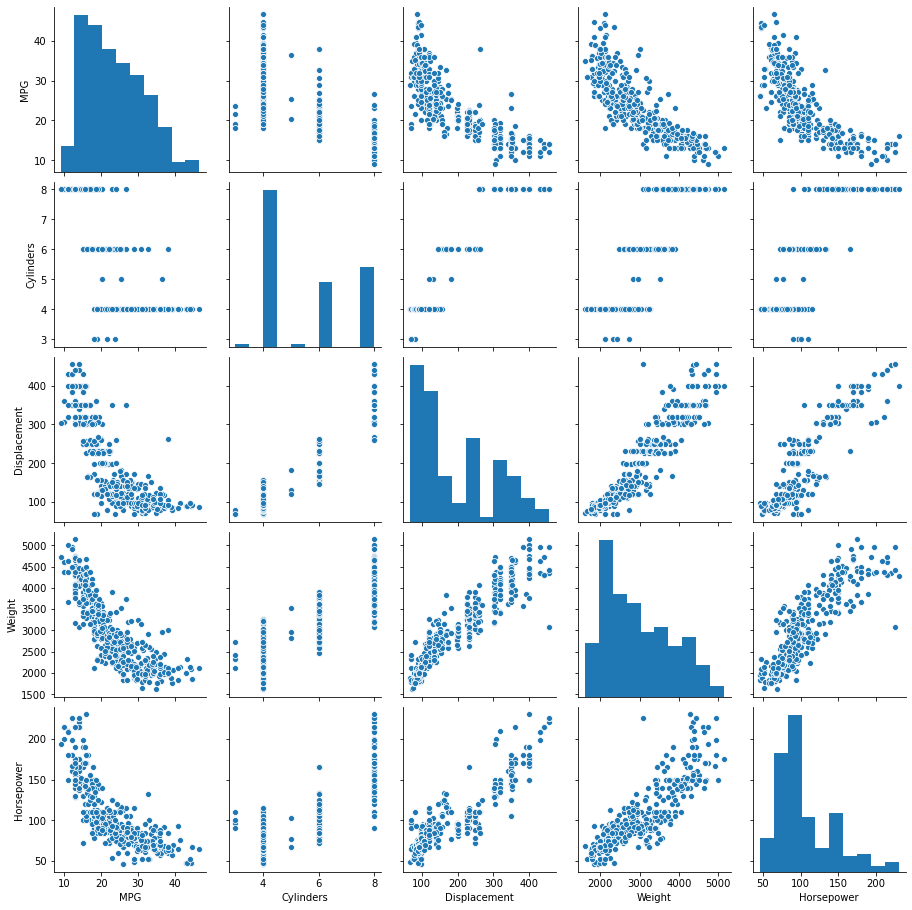

In [16]:
# pairplotsto get an intuition of potential correlations
sns.pairplot(df1[['MPG', 'Cylinders', 'Displacement', 'Weight', 'Horsepower']])

## Step 3: Data Preparation

1. Handling Categorical Attribute - OneHotEncoder
2. Data Cleaning - Imputer
3. Attribute Addition - Adding custom transformation
4. Setting up Data Transformation Pipeline for numerical and categorical column.

In [11]:
df2 = df1.copy()

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df2, df2['Cylinders']):
    strat_train_set = df2.loc[train_index]
    strat_test_set = df2.loc[test_index]

### Segregating Target and Feature variables

In [13]:
df2 = strat_train_set.drop('MPG', axis=1)
df2_labels = strat_train_set['MPG'].copy()

### Preprocessing the Origin Column

In [14]:
def preprocess_origin_cols(df):
    df['Origin'] = df['Origin'].map({1: 'India', 2: 'USA', 3: 'Germany'})
    return df

df_tr = preprocess_origin_cols(df2)
df_tr.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
145,4,83.0,61.0,2003.0,19.0,74,Germany
151,4,79.0,67.0,2000.0,16.0,74,USA
388,4,156.0,92.0,2585.0,14.5,82,India
48,6,250.0,88.0,3139.0,14.5,71,India
114,4,98.0,90.0,2265.0,15.5,73,USA


### One Hot Encoding the Origin Column

In [15]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 145 to 362
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cylinders     318 non-null    int64  
 1   Displacement  318 non-null    float64
 2   Horsepower    318 non-null    float64
 3   Weight        318 non-null    float64
 4   Acceleration  318 non-null    float64
 5   Model Year    318 non-null    int64  
 6   Origin        318 non-null    object 
dtypes: float64(4), int64(2), object(1)
memory usage: 19.9+ KB


In [16]:
# isolating the origin column
df_cat = df_tr[['Origin']]
df_cat.head()

,Origin
145,Germany
151,USA
388,India
48,India
114,USA


In [17]:
# Onehotencoding the categorical values
cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)
df_cat_1hot # returns a sparse matrix

<318x3 sparse matrix of type '<class 'numpy.float64'>'
	with 318 stored elements in Compressed Sparse Row format>

In [18]:
df_cat_1hot.toarray()[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [19]:
cat_encoder.categories_

[array(['Germany', 'India', 'USA'], dtype=object)]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
145,4,83.0,61.0,2003.0,19.0,74,Germany
151,4,79.0,67.0,2000.0,16.0,74,USA
388,4,156.0,92.0,2585.0,14.5,82,India
48,6,250.0,88.0,3139.0,14.5,71,India
114,4,98.0,90.0,2265.0,15.5,73,USA
383,4,91.0,67.0,1965.0,15.0,82,Germany
85,8,350.0,175.0,4100.0,13.0,73,India
234,4,151.0,88.0,2740.0,16.0,77,India
229,8,400.0,180.0,4220.0,11.1,77,India
225,6,250.0,110.0,3520.0,16.4,77,India
